In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import linear_sum_assignment
import os
import skimage.transform as transform
import cv2

plt.style.use('dark_background')

In [2]:
animal_type = 'GZ'
video_name = 'observation061'

base_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/' + video_name + '/localizations'
 


boxes_file = os.path.join(base_file, 'boxes.npy')
classes_file = os.path.join(base_file, 'classes.npy')
scores_file = os.path.join(base_file, 'scores.npy')
positions_file = os.path.join(base_file, 'positions.npy')
drone_movement_matrices_file = os.path.join(base_file, 'drone_movement_matrices.npy')

track_file = os.path.join(base_file, 'tracks-complete.npy')


#Have the bounding boxes already been converted to postions
positions_exists = os.path.isfile(positions_file)
if positions_exists:
    print('Using already computed postions.  Ignoring box files...')
#Do the tracks have classe labels
classes_exists = os.path.isfile(classes_file)
if classes_exists:
    print('Using classes')
    
scores_exists = os.path.isfile(scores_file)
if scores_exists:
    print('Using scores')
    
tracks_exists = os.path.isfile(track_file)
if tracks_exists:
    print('Using tracks')
    
drone_matrices_exists = os.path.isfile(drone_movement_matrices_file)
if drone_matrices_exists:
    print('Using drone warps')
 

use_heads = False

if use_heads:
    head_base_file = '/media/golden/72FFC6EE48B5CF39/kenya-tracking/head-annotations/test_extract'
    head_boxes_file = os.path.join(head_base_file, 'boxes.npy') 
    head_classes_file = os.path.join(head_base_file, 'classes.npy') 
    head_scores_file = os.path.join(head_base_file, 'scores.npy')  
    head_positions_file = os.path.join(head_base_file, 'head-positions.npy')



Using already computed postions.  Ignoring box files...
Using classes
Using scores
Using tracks


In [3]:
def _get_boxes_center(boxes, frame_width, frame_height):
    center = np.ones((boxes.shape[0], 2))
    #need to convert from top right to bottom right origin
    center[:, 0] = (frame_height - 
                    (frame_height * (boxes[:, 0] + (boxes[:, 2] - boxes[:, 0]) / 2.0))) 
    center[:, 1] = frame_width * (boxes[:, 1] + (boxes[:, 3] - boxes[:, 1]) / 2.0)
#     center[:, 0] = (boxes[:, 0] + ((boxes[:, 2] - boxes[:, 0]) / 2.0)) 
#     center[:, 1] = (boxes[:, 1] + ((boxes[:, 3] - boxes[:, 1]) / 2.0))
    return center

def _get_head_position(head_box, box, frame_width, frame_height):
    head_center = np.ones(2)

    #first get center of the head_box
    head_center[0] = (box[2] - box[0]) * frame_height * (head_box[0] + (head_box[2] - head_box[0]) / 2) 
    head_center[1] = (box[3] - box[1]) * frame_width * (head_box[1] + (head_box[3] - head_box[1]) / 2)
    
    head_position = np.ones(2)
    
    head_position[0] = frame_height - (box[0] * frame_height + head_center[0])
    head_position[1] = box[1] * frame_width + head_center[1]
    

    
    return head_position

In [4]:
if not positions_exists or use_heads:
    boxes_list = np.load(boxes_file)
    print('length of boxes list:', len(boxes_list))
    boxes_list = np.squeeze(boxes_list)

if classes_exists:
    classes_list = np.load(classes_file)
    print('length of classes list:', len(classes_list))
    classes_list = np.squeeze(classes_list)

if drone_matrices_exists:
    drone_matrices_list = np.load(drone_movement_matrices_file)
    print('length of drone movement list:', len(drone_matrices_list))
    
if positions_exists:
    positions = np.load(positions_file)
    print('length of positions list:', len(positions))
    positions = np.squeeze(positions)
    
if scores_exists:
    scores_list = np.load(scores_file)
    print('length of scores list:', len(scores_list))
    scores_list = np.squeeze(scores_list)
    
if tracks_exists:
    tracks_list = np.load(track_file)
    tracks_list = [tracks_list[track] for track in range(tracks_list.shape[0])]

frame_width = 3840
frame_height = 2160

length of classes list: 59975
length of positions list: 59975
length of scores list: 59975


In [5]:
score_thresh = .35
if not tracks_exists:
    for ind in range(len(scores_list)):
        scores = scores_list[ind]
        if positions_exists:
            positions[ind] = positions[ind][np.where(scores > score_thresh)]
        else:
            boxes_list[ind] = boxes_list[ind][np.where(scores > score_thresh)]
        classes_list[ind] = classes_list[ind][np.where(scores > score_thresh)]
        scores_list[ind] = scores_list[ind][np.where(scores > score_thresh)]

(array([ 19299.,  16103.,  14220.,  13288.,  13204.,  14189.,  16866.,
         23136.,  43909., 605898.]),
 array([0.30000123, 0.36999294, 0.43998465, 0.5099764 , 0.5799681 ,
        0.6499598 , 0.7199515 , 0.7899432 , 0.8599349 , 0.92992663,
        0.99991834], dtype=float32),
 <a list of 10 Patch objects>)

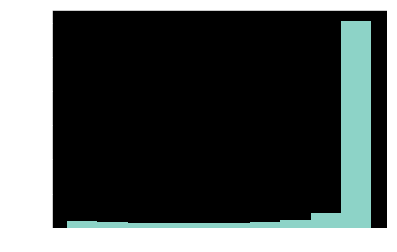

In [6]:
low_scores = []
for step_scores in scores_list:
    if len(step_scores) != 0:
        if step_scores.min() < 1:
            for score_ind in range(step_scores.shape[0]):
                low_scores.append(step_scores[score_ind])
plt.hist(low_scores)

In [7]:

# if use_heads:
#     head_boxes_list_raw = np.load(head_boxes_file)
#     head_classes_list_raw = np.load(head_classes_file)
#     head_scores_list_raw = np.load(head_scores_file)

#     head_positions_list = []

#     #registering the buffalo heads with the correct buffalo boxes
#     head_count = 0
#     for boxes_ind, boxes in enumerate(boxes_list):
#         if boxes_ind % 50000 == 0:
#             print(boxes_ind)
#         head_positions_list.append([])
#         for box_ind, box in enumerate(boxes):
#             if head_boxes_list_raw[head_count].shape[0] == 0:
#                 head_positions_list[boxes_ind].append((0,0))
#                 head_count += 1
#                 continue
#             head_box = head_boxes_list_raw[head_count][0,:]
#             head_box = np.squeeze(head_box)
#             head_count += 1
#             head_position = _get_head_position(head_box, box, frame_width, frame_height)
#             head_positions_list[boxes_ind].append(head_position)
#     #     print(boxes_ind, head_positions_list[boxes_ind])
#     print(head_count)
#     np.save(head_positions_file, head_positions_list)

In [8]:
#get positions from boxes -> take the center of the box for the position
if not positions_exists:
    positions = []

    for boxes in boxes_list:
        positions.append(_get_boxes_center(boxes, frame_width, frame_height))

    np.save(positions_file, positions)
    print(len(positions))
    raw_positions = list(positions)

In [9]:

#Threshold out detection that have too low of a score
# score_threshold = .6

# positions = []

# for step_count, position_matrix in enumerate(raw_positions):
#     positions.append(position_matrix[np.where(scores_list[step_count]>score_threshold)])

average number of individuals 12.770070862859525
most common number of individuals 13


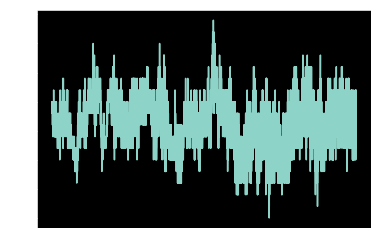

In [10]:
shape = []
for frame in range(len(positions)):
    shape.append(positions[frame].shape[0])
    
plt.plot(shape)
print('average number of individuals', sum(shape) / len(shape))

expected_individuals = max(set(shape), key=shape.count)

print('most common number of individuals', expected_individuals)

In [11]:
if use_heads:
    np.expand_dims(head_positions_list[0][0], 0).shape

In [12]:
def normalize(vec):

    if len(vec.shape) == 2:
        vec_mag = np.sqrt(vec[:, 0] ** 2 + vec[:, 1] ** 2)
    else:
        vec_mag = np.squeeze(np.sqrt(vec[0] ** 2 + vec[1] ** 2))
    return(np.expand_dims(vec / vec_mag, 0))

#create the dictionary which discribes a new track
# last_frame: frame in which it was last seen
def create_new_track(first_frame, first_position, pos_index, class_label=None, head_position=None, noise=1):
    new_track = {'track': np.expand_dims(first_position, 0),
                'first_frame': first_frame,
                'last_frame': first_frame, 
                'pos_index': np.expand_dims(pos_index, 0),
                'class': [class_label],
                # Sometimes a false point will momentarily pop up
                # Treating this noise as a real track causes problems because it constrains the search
                # space of a real nearby track
                # only treat a track as a real track if it's been added to
                'noise': noise
                }
    if head_position is not None:
        head_vector = np.expand_dims(head_position - first_position, 0)
        new_track['head_vector'] =  head_vector
        new_track['head'] =  np.expand_dims(head_position, 0)
    
    return new_track
        
#returns an array of shape (len(active_list), positions1.shape[0])
#row is distance from every new point to last point in row's active list
def calculate_distances(positions1, track_list, active_list):
    #positions from last step
    positions0 = np.vstack((track_list[track_num]['track'][-1, :] for track_num in active_list))
#     print('positions1.shape', positions1.shape)
#     print('positions0.shape', positions0.shape)


    x_diff = np.expand_dims(positions1[:, 1], 0) - np.expand_dims(positions0[:, 1], 1)

    y_diff = np.expand_dims(positions1[:, 0], 0) - np.expand_dims(positions0[:, 0], 1)
    distance = np.sqrt(x_diff ** 2 + y_diff ** 2)
    return distance

def calculate_active_list(track_list, max_unseen_time, frame_num):
    active_list = []
    for track_num in range(len(track_list)):
        if frame_num - track_list[track_num]['last_frame'] <= max_unseen_time:
            active_list.append(track_num)
    return active_list

def calculate_max_distance(track_list, active_list, max_distance):
    # only check distances to established tracks
    positions0 = np.expand_dims(track_list[active_list[0]]['track'][-1, :], 0)
    if len(active_list) > 1:
        for track_num in active_list[1:]:
            if track_list[track_num]['noise'] <= 0:
                positions0 = np.vstack((positions0, track_list[track_num]['track'][-1, :]))
    distance = calculate_distances(positions0, track_list, active_list)
    # closest point will be itself, so make zero distance bigger than other distances
    distance[np.where(distance == 0)] = frame_width * 2 
    # HYPER PARAMETER
    # divide by three because saying that within a third of distance to neighbor much more likely to be
    # you then them
    closest_neighbor = np.min(distance, 1) * .4
    # Even if neighbors are all far away, have a max threshold to look for new points 
    closest_neighbor[np.where(closest_neighbor > max_distance)] = max_distance
    for active_ind, track_num in enumerate(active_list):
        track_list[track_num]['max_distance'] = closest_neighbor[active_ind] 
    return track_list
    
        

In [13]:
drone_movement_exists = False
# if drone_movement_exists:
#     net_drone_movement = [np.eye(3)]
#     movement_transform = []
#     for matrix in drone_matrices_list: 
#         net_drone_movement.append(np.matmul(net_drone_movement[-1], matrix))
#         movement_transform.append(transform.AffineTransform(net_drone_movement[-1]))
# else:
#     net_drone_movement = None

if not tracks_exists:
    raw_track_list = []

    max_distance_threshold = 70
    max_unseen_time = 20

    class_label = None
    head_position = None

    start_frame = 0 
    end_frame = len(positions) # len(positions)
#     end_frame = 100

    #Create initial tracks based on the objects in the first frame
    for ind in range(positions[start_frame].shape[0]):
        #each track entry is both an array that store all points added to the track and a value that
        #indicates the frame on which the track begins

        if classes_exists:
            class_label = classes_list[start_frame][ind]
        raw_track_list.append(create_new_track(
            start_frame, positions[start_frame][ind], ind, class_label, head_position, noise=0)) 

    #try to connect points to the next frame
    for frame in range(start_frame + 1, end_frame):
        if frame % 1000 == 0:
            print('frame number', frame, 'processed')

        #get tracks that are still active (have been seen within the specified time)
        active_list = calculate_active_list(raw_track_list, max_unseen_time, frame)
        #positions from the next step
        positions1 = positions[frame]
        
        # Make sure there are new points to add
        if len(positions1) != 0:

            raw_track_list = calculate_max_distance(raw_track_list, active_list, max_distance_threshold)

            #No existing tracks to connect to
            if len(active_list) == 0:
                #Every point in next frame must start a new track
                for position in range(positions1.shape[0]):
                    if classes_exists:
                        class_label = classes_list[frame][position]
                    if use_heads:
                        head_position = head_positions_list[frame][position]

                    raw_track_list.append(create_new_track(frame, positions1[position], position, class_label, head_position, noise=0))
                continue
            



            #returns an array of shape (len(active_list), positions1.shape[0])
            #row is distance from every new point to last point in row's active list 
            distance = calculate_distances(positions1, raw_track_list, active_list)
            
            max_distance = np.zeros_like(distance)
            
            for active_num, track_num in enumerate(active_list):
                max_distance[active_num, :] = raw_track_list[track_num]['max_distance']
            is_max_distance = distance > max_distance
            new_track = np.all(is_max_distance, 0)


            if np.any(new_track):
                for t in np.where(new_track)[0]:
                    if classes_exists:
                        class_label = classes_list[frame][t]
                    if use_heads:
                        head_position = head_positions_list[frame][t]

                    raw_track_list.append(create_new_track(frame, positions1[t], t, class_label, head_position)) 

            #connect the dots from one frame to the next
            row_ind, col_ind = linear_sum_assignment(distance)

            #see if points got assigned to tracks that are farther than max_threshold_distance
            #This happens when the closer track gets assigned to a differnt point
            bad_assign = distance[row_ind, col_ind] > max_distance[:, 0][row_ind]
            if np.any(bad_assign):
                bad_assign_points = np.where(bad_assign)[0]

                #Assign multiple tracks to nearby points, in cases where track got assigned to somewhere far away
                #because closer track got assigned to point first
                #this case could come up when two animals get too close so they merge to one point
                col_ind[bad_assign_points] = np.argmin(distance[row_ind[bad_assign_points],:], 1)

                # There may be some tracks that just have any new points near by.  Now filter those out
                valid_assign = distance[row_ind, col_ind] <= max_distance[:, 0][row_ind]
                col_ind = col_ind[valid_assign]
                row_ind = row_ind[valid_assign]
            
        active_list = np.array(active_list)

        for track_num in range(len(raw_track_list)):

            if track_num in active_list:

                #Case where there are new points in the next frame to add
                if track_num in active_list[row_ind] and len(positions1) != 0:
                    row_count = np.where(track_num == active_list[row_ind])
                    # If this is a refound track, linearly interpolate from when last seen
                    if raw_track_list[track_num]['last_frame'] != frame - 1:
                        missed_steps = frame - raw_track_list[track_num]['last_frame'] - 1
                        gap_distance = (
                            positions1[col_ind[row_count], :] - raw_track_list[track_num]['track'][-1, :])
                        step_distance = gap_distance / (missed_steps + 1)
                        for step in range(missed_steps):
                            raw_track_list[track_num]['track'][-step - 1, :] = (
                                raw_track_list[track_num]['track'][-step - 1, :] + 
                                (missed_steps - step) * step_distance)

                    raw_track_list[track_num]['track'] = np.vstack((raw_track_list[track_num]['track'], 
                                                                    positions1[col_ind[row_count], :]))
                    raw_track_list[track_num]['pos_index'] = np.vstack((raw_track_list[track_num]['pos_index'], col_ind[row_count]))

                    raw_track_list[track_num]['last_frame'] = frame
                    raw_track_list[track_num]['noise'] = 0
                    
                    
                        

                else:
                    raw_track_list[track_num]['track'] = np.vstack((raw_track_list[track_num]['track'], 
                                                                raw_track_list[track_num]['track'][-1, :]))
                    nan = np.empty((1,1))
                    nan[:] = np.nan
                    raw_track_list[track_num]['pos_index'] = np.vstack(
                        (raw_track_list[track_num]['pos_index'], nan))
                    # isn't a confirmed real track yet
                    if raw_track_list[track_num]['noise'] != 0:
                        raw_track_list[track_num]['noise'] += 1
                        
        # Traverse the list in reverse order so if there are multiple tracks that
        # need to be removed the indexing doesn't get messed up 
        for track_num in range(len(raw_track_list) - 1, -1, -1): 
            if raw_track_list[track_num]['noise'] >= 2:
                del raw_track_list[track_num]
                
        
        
#         if frame % 500 == 0:
#             plt.figure(figsize=(20,12))
#             print('num tracks', len(raw_track_list))
#             for track in raw_track_list:
#                 plt.plot(track['track'][:,1], track['track'][:,0], linewidth=5)

else:
    raw_track_list = tracks_list


In [14]:
if not tracks_exists:
    #THIS IS THE PART THAT GETS RID OF THE EXTRA PART OF THE TRAIL

    #'last_seen' tells the number of extra points at the end of track that were added hopping that the point would reapear 
    #nearby.  Since the tracking is now finished.  We can now get rid of these extra points tacked on to the end

    num_frames = end_frame - start_frame
    print(end_frame)



    for track in raw_track_list:
        old_shape = track['track'].shape[0]
        track['track'] = track['track'][:track['last_frame'] - track['first_frame'] + 1]
        track['pos_index'] = track['pos_index'][:track['last_frame'] - track['first_frame'] + 1]

#         if track['last_seen'] < end_frame - 1:
#             if end_frame -1  - track['last_seen'] < max_unseen_time:
#                 print(end_frame  - track['last_seen'])
#                 track['track'] = track['track'][:-(end_frame -1 - track['last_seen'])]

#         track['last_seen'] += 1

        

        

number of tracks without min threshold 308


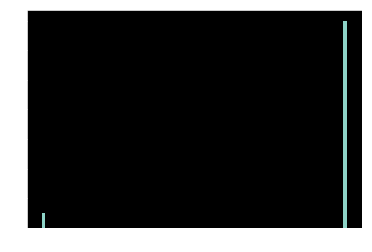

number of tracks above min threshold 15


In [15]:
print('number of tracks without min threshold' , len(raw_track_list))

min_length_threshold = 10000

track_lengths = []
track_list = []
for track_num, track in enumerate(raw_track_list):
    track_length = track['track'].shape[0]
    if track_length >= min_length_threshold:
        track_lengths.append(track['track'].shape[0])
        track_list.append(track)
    
plt.hist(track_lengths, bins=100)
plt.show()
print('number of tracks above min threshold' , len(track_lengths))

In [16]:
save = True
track_file = os.path.join(base_file, 'tracks.npy')
if save:
    np.save(track_file, track_list)

In [25]:
for track_id, track in enumerate(track_list):
    if len(track['track']) + track['first_frame'] - 1 != track['last_frame']:
        print('error')
        print('track_num:', track_id)
        print('len', len(track['track']) )
        print('fframe:', track['first_frame'])
        print('lframe:', track['last_frame'])

In [26]:
if False:
    if drone_movement_exists:
        # compute and display the commulative drone movement
        net_drone_movement = np.cumsum(drone_movement_list, 0)
        plt.figure()
        plt.scatter(-net_drone_movement[:,0], -net_drone_movement[:, 1],
                    c=np.arange(len(drone_movement_list)))
        axes = plt.gca()
        axes.set_xlim([-frame_width/2, frame_width/2])
        axes.set_ylim([-frame_height/2, frame_height/2])
        print(net_drone_movement[-1,:])

In [19]:
# This matricies were calculated from images downsampled by 2
# Fix the translations to account for this

for matrix_ind in range(drone_matrices_list.shape[0]):
    drone_matrices_list[matrix_ind][:2,2] = drone_matrices_list[matrix_ind][:2,2] * 2 

In [36]:
import skimage.transform as transform
import copy


#     temp = copy.copy(drone_matrices_list[matrix_ind][0,:])
#     drone_matrices_list[matrix_ind][0,:] = copy.copy(drone_matrices_list[matrix_ind][1,:])
#     drone_matrices_list[matrix_ind][1,:] = temp
# calculate net drone movement at each frame

drone_movement_exists = True
if drone_movement_exists:
    net_drone_movement = [np.eye(3)]
    movement_transform = []
    for matrix in drone_matrices_list: 
        net_drone_movement.append(np.matmul(net_drone_movement[-1], matrix))
print(net_drone_movement[4000])
print(net_drone_movement[5000])
print(net_drone_movement[5800])

[[ 9.99229633e-01 -2.78887353e-03 -3.59665319e+02]
 [ 2.78887353e-03  9.99229633e-01  1.43865997e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00629830e+00  1.24934436e-03 -2.55710409e+02]
 [-1.24934436e-03  1.00629830e+00  3.04173213e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-7.00404766e-01 -7.37957383e-01  3.52285497e+03]
 [ 7.37957383e-01 -7.00404766e-01  2.26409268e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [21]:
import copy
# create tracks with drone movement compensation

raw_track_list = copy.deepcopy(track_list)

In [22]:
import cv2
test = np.ones((len(movement_transform), 2))

for track_ind, _ in enumerate(track_list[:]):
#     track_list[track_ind]['track'] = np.hstack([track_list[track_ind]['track'], np.ones((track_list[track_ind]['track'].shape[0], 1))])
    track_xy = np.hstack([-track_list[track_ind]['track'][:,1:], track_list[track_ind]['track'][:,0:1]])
#     track_xy = np.hstack([track_list[track_ind]['track'][:,1:], track_list[track_ind]['track'][:,0:1]])
    for step in range(track_list[track_ind]['track'].shape[0]):
#     for step in range(9000,9010):
#         track_list[track_ind]['track'][step] = np.matmul(net_drone_movement[step], track_list[track_ind]['track'][step])
       track_xy[step] = cv2.perspectiveTransform(np.expand_dims(track_xy[step:step+1].astype(np.float32), 0), net_drone_movement[step])
#         track_xy[step] = cv2.perspectiveTransform(track_xy[step].astype(np.float32), net_drone_movement[step])
#         track_list[track_ind]['track'][step] = movement_transform[step].inverse(track_list[track_ind]['track'][step])
#     track_list[track_ind]['track'] = track_list[track_ind]['track'][:,:2]
    track_list[track_ind]['track'] =np.hstack([track_xy[:,1:], track_xy[:,0:1]])

for step in range(test.shape[0]):
#     test[step] = movement_transform[step].inverse(test[step])
    test[step] = cv2.perspectiveTransform(np.expand_dims(test[step:step+1].astype(np.float32), 0), net_drone_movement[step])
    
    

In [23]:
track_xy_list = copy.deepcopy(track_list)

for track_ind, _ in enumerate(track_xy_list[:]):
    track_xy_list[track_ind]['track'] = np.hstack([-track_xy_list[track_ind]['track'][:,1:], track_xy_list[track_ind]['track'][:,0:1]])

In [24]:
import pandas as pd
#create csv
positions_file = np.empty((len(drone_matrices_list), len(track_xy_list) * 2))
positions_file.fill(np.nan)
for track_ind, track in enumerate(track_xy_list):
    positions_file[track['first_frame']:track['first_frame']+track['track'].shape[0], track_ind*2:track_ind*2+2] = track['track']

# Data frame column labels
column_names = []
for ind in range(len(track_xy_list) * 2):
    xy = ''
    if ind % 2 == 0:
        xy = 'x'
    else:
        xy = 'y'
    column_names.append('track_' + str(ind//2) + '_' + xy)
positions_df = pd.DataFrame(positions_file, columns=column_names)
video_name = base_file.split('/')[-2]
# positions_df.to_csv(os.path.join(base_file, video_name + '-tracks.csv'))

In [25]:
# test_df = pd.read_csv(os.path.join(base_file, video_name + '-tracks.csv'))

In [26]:
# np.save(os.path.join(base_file, 'tracks-xy-drone-comp.npy'), track_xy_list)

In [27]:
# import pandas as pd

# file = '/media/golden/72FFC6EE48B5CF39/drone_tracking/kenya-tracking/processed_videos/APR08_2018_C_DJI_0010/localizations/APR08_2018_C_DJI_0010-tracks.csv' 

# df = pd.read_csv(file)

# first_row = df.loc[1]
# print(first_row[1])

In [28]:
# frame_width = 4096
# frame_height = 2160

# real_image_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/raw_frames/scare_clips/GZ/APR08_2018_C_DJI_0010/APR08_2018_C_DJI_0010_2.jpg'
# real_image = cv2.imread(real_image_file)
# for track in range(len(track_xy_list)):
#     cv2.circle(real_image, (int(first_row[track*2 + 1]), frame_height - int(first_row[2 + track*2])), 20, (1.0, 1.0, 0.0), -1)

# plt.imshow(real_image)

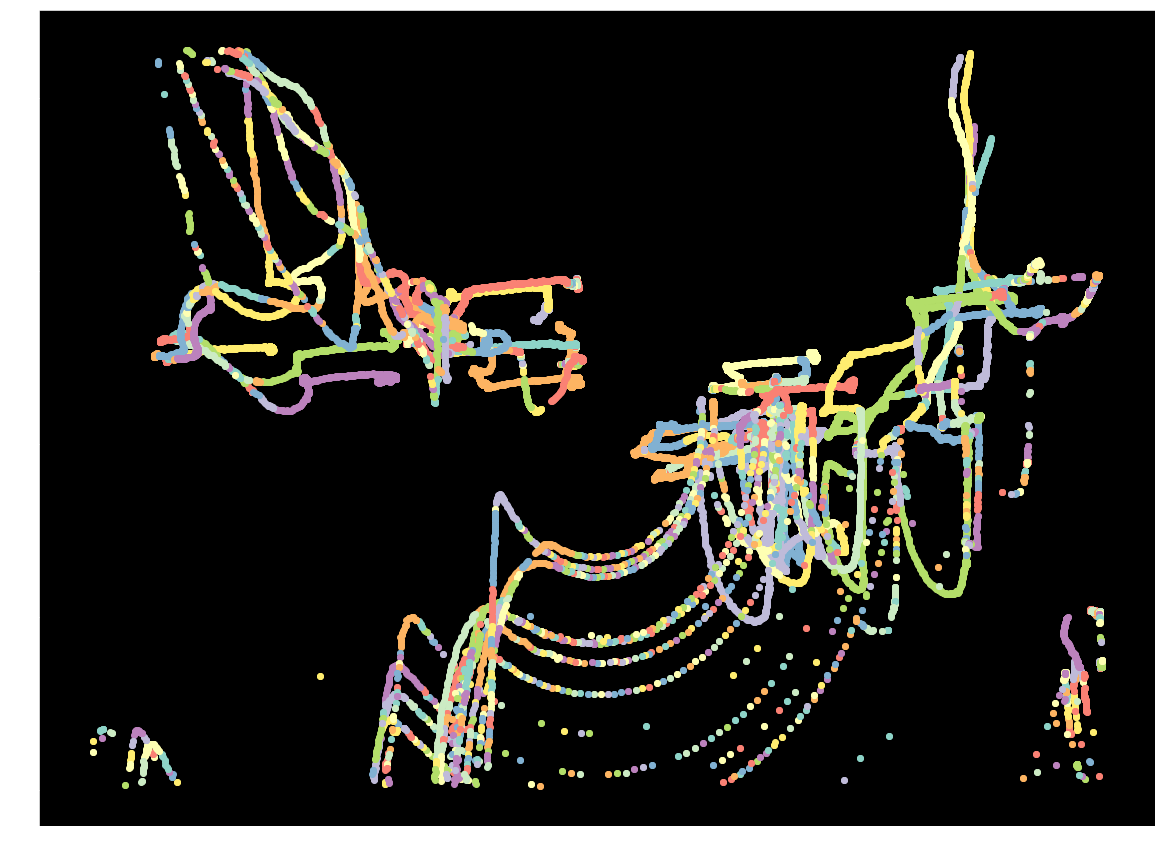

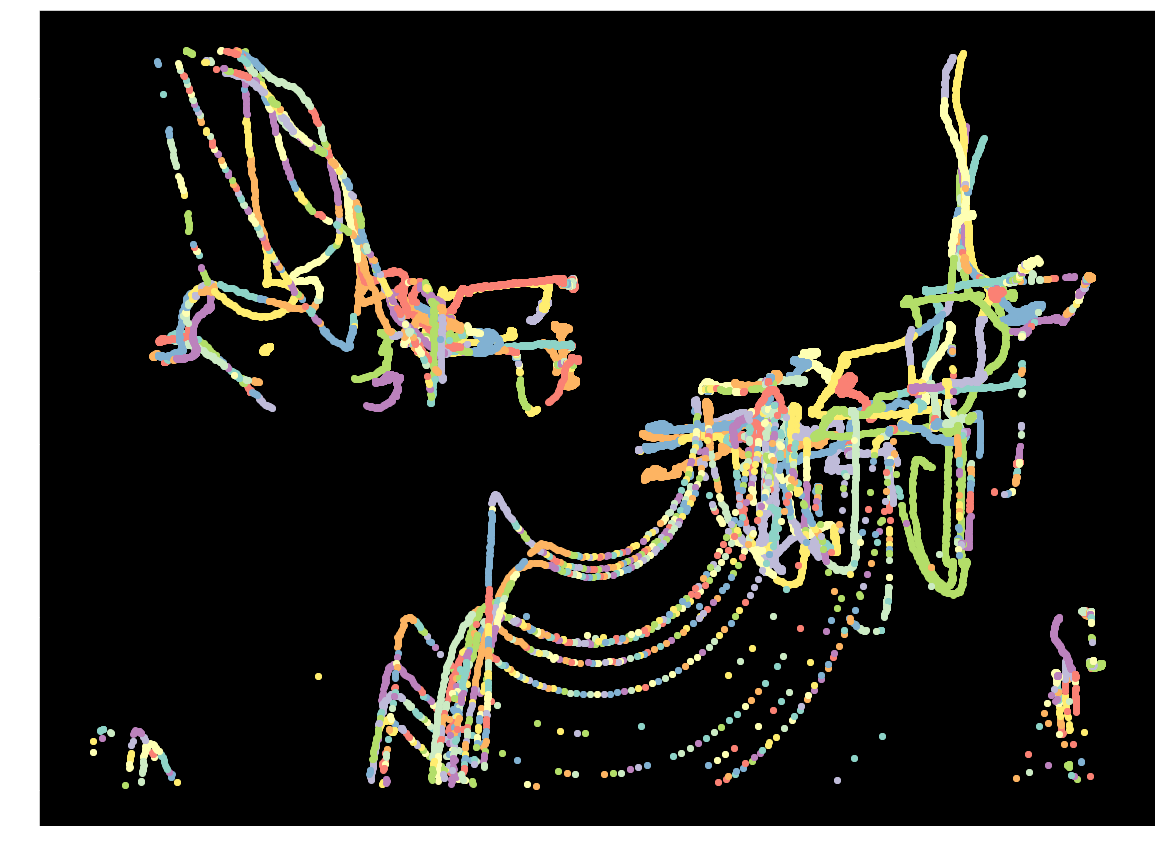

In [30]:
plt.figure(figsize=(20, 15))
# for track_ind in range(len(track_xy_list)):
for track_ind in range(len(track_list)):
    plt.scatter(raw_track_list[track_ind]['track'][:,1], raw_track_list[track_ind]['track'][:,0]  )
    
plt.figure(figsize=(20, 15))
# for track_ind in range(len(track_xy_list)):
for track_ind in range(len(track_xy_list)):
    plt.scatter(track_xy_list[track_ind]['track'][:,0], track_xy_list[track_ind]['track'][:,1]  )

[3255.52441406 -276.43154907]
(5850, 2)


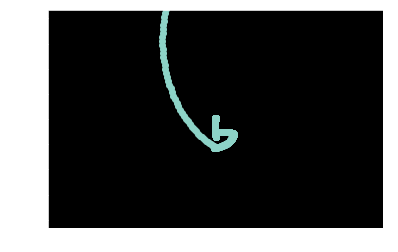

In [55]:
plt.scatter(test[0:,1], test[0:,0])
plt.axis([-4096,4096,-2160,2160])
print(test[-1])
print(test.shape)

(554, 2)


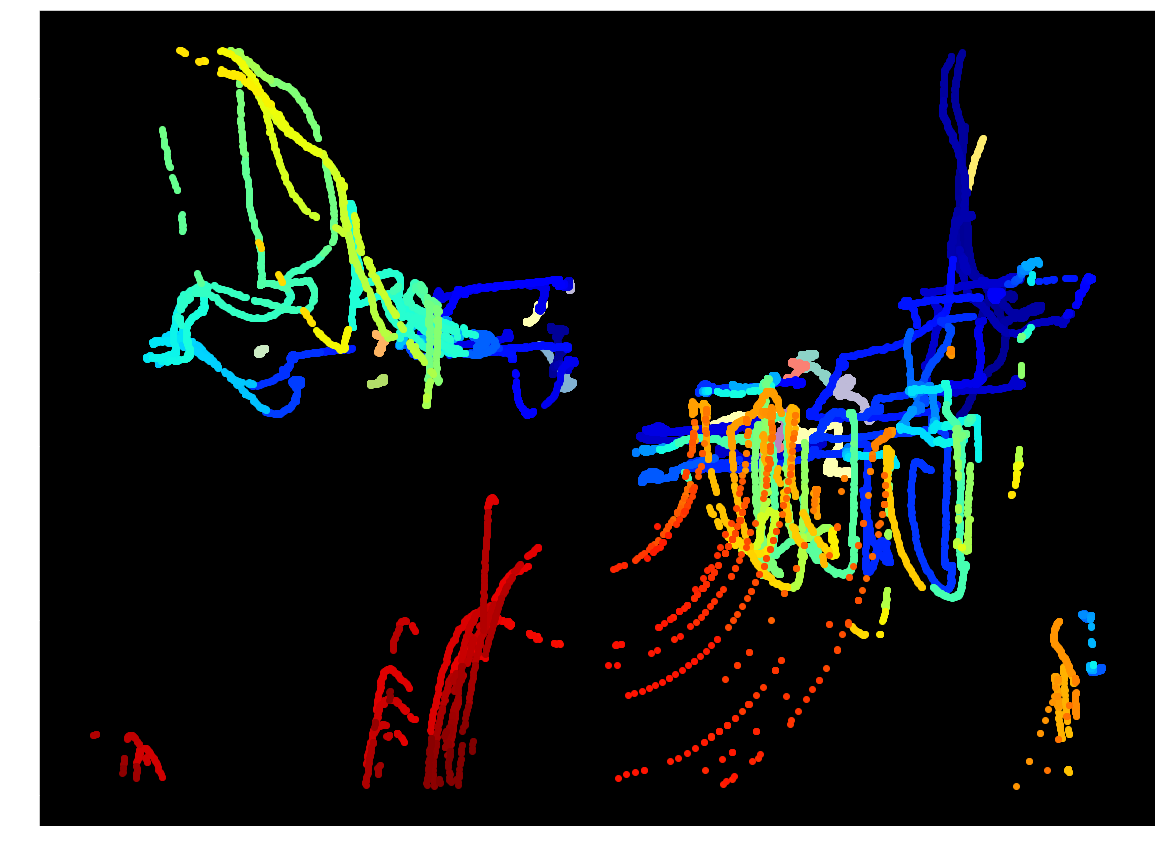

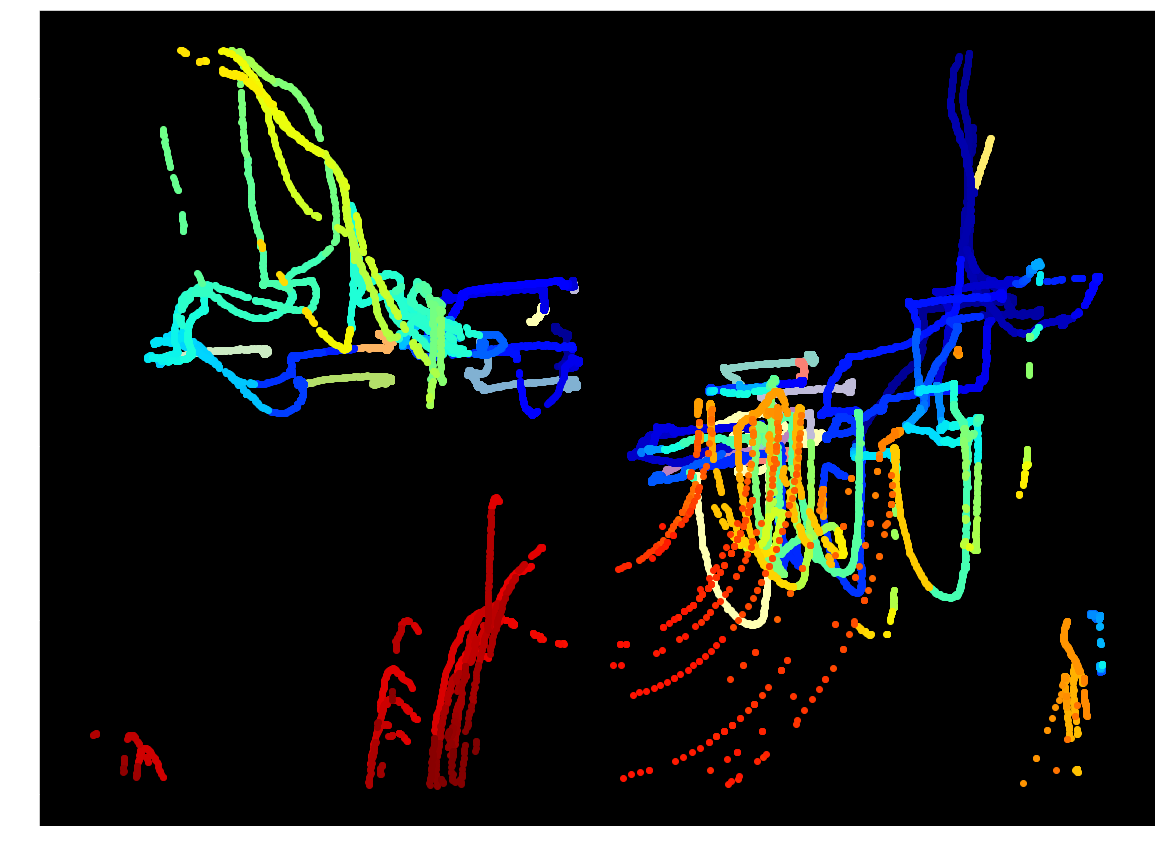

In [56]:


show_non_starting_tracks = True

step_count = None
print(track_list[0]['track'].shape)
#RAW PLOT
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(track_list)))
plt.figure(figsize=(20, 15))

for track_num in range(1,len(track_list)):
#     for track in range(1,15):
#     plt.figure()
    if track_num < 15:
#         plt.figure()
        plt.scatter(-(track_list[track_num]['track'][:step_count,1]),
                    (track_list[track_num]['track'][:step_count,0]))
    else:
        if show_non_starting_tracks:
            plt.scatter(-(track_list[track_num]['track'][:step_count,1]),
                        (track_list[track_num]['track'][:step_count,0]),
                        color=colors[track_num])
            
            
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(track_list)))
plt.figure(figsize=(20, 15))
for track_num in range(1,len(raw_track_list)):
#     for track in range(1,15):
#     plt.figure()
    if track_num < 15:
#         plt.figure()
        plt.scatter((raw_track_list[track_num]['track'][:step_count,1]),
                    (raw_track_list[track_num]['track'][:step_count,0]))
    else:
        if show_non_starting_tracks:
            plt.scatter((raw_track_list[track_num]['track'][:step_count,1]),
                        (raw_track_list[track_num]['track'][:step_count,0]),
                        color=colors[track_num])

# if drone_movement_exists:
if False:
    #DRONE MOVEMENT COMP PLOT
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(track_list)))
    plt.figure(figsize=(15, 10))
    for track_num in range(1,len(track_list)):
    #     for track in range(1,15):
    #     plt.figure()
        if track_list[track_num]['first_frame'] == 0:
    #         plt.figure()
            plt.scatter((track_list[track_num]['track'][:step_count,1] - 
                         net_drone_movement[track_list[track_num]['first_frame']:(len(track_list[track_num]['track']) + track_list[track_num]['first_frame']), 0]),
                        (track_list[track_num]['track'][:step_count,0] + 
                         net_drone_movement[track_list[track_num]['first_frame']:(len(track_list[track_num]['track']) + track_list[track_num]['first_frame']), 1]))
        else:
            if show_non_starting_tracks:
                net_drone_movement = np.cumsum(
                    drone_movement_list[track_list[track_num]['first_frame']:(len(track_list[track_num]['track']) + track_list[track_num]['first_frame']), :], 0) 

                plt.scatter((track_list[track_num]['track'][:step_count, 1] - net_drone_movement[:, 0]),
                            (track_list[track_num]['track'][:step_count, 0] + net_drone_movement[:, 1]),
                        color=colors[track_num])
        

In [30]:

print(len(track_list))

def plot_tracks(num_steps, fine_tuning_steps, with_drone_movement=False):
    
    cmap = plt.get_cmap('tab20')
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(track_list)))
    
    figure = plt.figure()
    plt.axis([-4096,4096,-2160,5000])
    figure.set_size_inches(20,13)
    
    num_steps = num_steps + fine_tuning_steps

    for track_num in range(1, len(track_list)):
        
        track = track_list[track_num]

        relative_step_number = num_steps - track['first_frame'] + 1 
        #Make sure track has begun but hasn't ended in num_steps
        if relative_step_number > 0 and (track['first_frame'] + track['track'].shape[0]) > num_steps:
            if with_drone_movement:
                net_drone_movement = np.cumsum(
                    drone_movement_list[track['first_frame']:(num_steps + 1), :], 0) 

                plt.scatter((track['track'][:relative_step_number, 1] - net_drone_movement[:, 0]),
                                (track['track'][:relative_step_number, 0] + net_drone_movement[:, 1]), c=colors[track_num])
            else:
                plt.scatter((-track['track'][:relative_step_number, 1]),
                                (track['track'][:relative_step_number, 0]), c=colors[track_num])
                
#     plt.scatter(-test[:num_steps, 0],
#                                 test[:num_steps, 1], c='w')

  
                
def plot_positions(num_steps, fine_tune_steps):
    
    track_tail_length = 5
    
    figure = plt.figure()
    figure.set_size_inches(20,13)
    plt.axis([-4096,4096,-2160,5000])
    
    num_steps = num_steps + fine_tune_steps

    for track_num in range(1, len(track_list)):

        relative_step_number = num_steps - track_list[track_num]['first_frame']  
        if relative_step_number > 0: 
            plt.scatter(-track_list[track_num]['track'][relative_step_number-track_tail_length:relative_step_number+1,1], 
                        track_list[track_num]['track'][relative_step_number-track_tail_length:relative_step_number+1,0], color=colors[track_num])

1107


In [31]:
from ipywidgets import widgets
from IPython.display import display

fine_tuning = 500

if tracks_exists:
    start_frame = 0
    end_frame = track_list[-5]['track'].shape[0]
    print('end_frame', end_frame)

widgets.interact(plot_tracks, 
                num_steps=widgets.IntSlider(min=start_frame, max=end_frame - fine_tuning, step=1, value=7393),
                fine_tuning_steps=widgets.IntSlider(min=0, max=fine_tuning, value=0),
                with_drone_movement=False)

interactive(children=(IntSlider(value=7393, description='num_steps', max=9318, min=1), IntSlider(value=0, description='fine_tuning_steps', max=500), Checkbox(value=False, description='with_drone_movement'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_tracks>

In [32]:
from ipywidgets import widgets
from IPython.display import display

widgets.interact(plot_positions, 
                 num_steps=widgets.IntSlider(min=0, max=track_list[0]['track'].shape[0], value=100),
                 fine_tune_steps=widgets.IntSlider(min=0, max=200, value=100),
                )

interactive(children=(IntSlider(value=100, description='num_steps', max=6812), IntSlider(value=100, description='fine_tune_steps', max=200), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_positions>

In [2]:
x = np.ones((3,1,2))
y = np.arange(4)
y = np.expand_dims(y,1)
y = np.tile(y, (1,2))
y = np.expand_dims(y, 0)
print('x shape', x.shape)
print('x: \n', x)
print('y shape', y.shape)
print('y: \n', y)
print((y-x).shape)
print('\n', x-y)


NameError: name 'np' is not defined

In [3]:
import numpy as np

In [4]:
x = np.arange(10)

In [16]:
def add(x):
    first = x
    second = x 
    return first, second

In [17]:
w, y = add(10)

In [20]:
print(w, y)

20 10


In [28]:
x = np.ones(5)

In [29]:
x[:-3]

array([ 1.,  1.])

In [ ]:
for i in range (10):
    input()
    

In [17]:
x = np.arange(10) * 2

In [18]:
y = np.array([0,5,7])

In [19]:
x[y]

array([ 0, 10, 14])

In [22]:
6 in x[y]

False

In [ ]:
x = np.array